# Decision Trees on Heart Disease Dataset


During this experiment, we will investigate the maths and implement Decision Trees, Random Forests and Adaboost. We will use Pytorch to create and train these algorithms to predict heart diseases.



## Dataset

The models will be trained using the [Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease).
Fourteen features were selected among 76 attributes: 
1. age: age in years
2. sex:
    - 1: male
    - 0: female
3. cp: chest pain type
    - 0: asymptomatic
    - 1: atypical angina
    - 2: non-anginal pain
    - 3: typical angina
4. trestbps: resting blood pressure
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl
7. restecg: resting electrocardiographic results
    - 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
    - 1: normal
    - 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina 
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - 1: upsloping
    - 2: flat
    - 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal:
    - 3 : fixed defect
    - 6 : normal
    - 7 : reversable defect
14. disease:
    - 0: artery diameter narrowing < 50%
    - 1-3: artery diameter narrowing > 50%, close to 3 is very severe

In [2]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

### Read csv using Pandas

In [3]:
hdisease = pd.read_csv(os.path.join('data', 'processed.cleveland.data'))

In [4]:
# The data does not include the columns names, we did a little trick to add them
columns = {
    '63.0' : 'age',
    '1.0' : 'sex',
    '1.0.1' : 'cp',
    '145.0' : 'trestbps',
    '233.0' : 'chol',
    '1.0.2' : 'fbs',
    '2.0' : 'restecg',
    '150.0' : 'thalach',
    '0.0' : 'exang',
    '2.3' : 'oldpeak',
    '3.0' : 'slope',
    '0.0.1' : 'ca',
    '6.0' : 'thal',
    '0' : 'disease'
}
hdisease.rename(columns=columns, inplace=True)

### Replacing missing values

In [5]:
# Remove the severity of the disease, 0: healthy, 1: sick
hdisease.loc[hdisease['disease'] > 1, 'disease'] = 1

# Setting gather unknown value and assign a new class for them
hdisease.loc[hdisease['ca'] == '?', 'ca'] = 4.0
hdisease.loc[hdisease['thal'] == '?', 'thal'] = 0.0

# Setting all values to float
hdisease = hdisease.astype(float)

In [6]:
hdisease.head()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
1  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
2  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
3  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
4  56.0  1.0  2.0     120.0  236.0  0.0      0.0    178.0    0.0      0.8   

   slope   ca  thal  disease  
0    2.0  3.0   3.0      1.0  
1    2.0  2.0   7.0      1.0  
2    3.0  0.0   3.0      0.0  
3    1.0  0.0   3.0      0.0  
4    1.0  0.0   3.0      0.0

### Correlation Heatmap

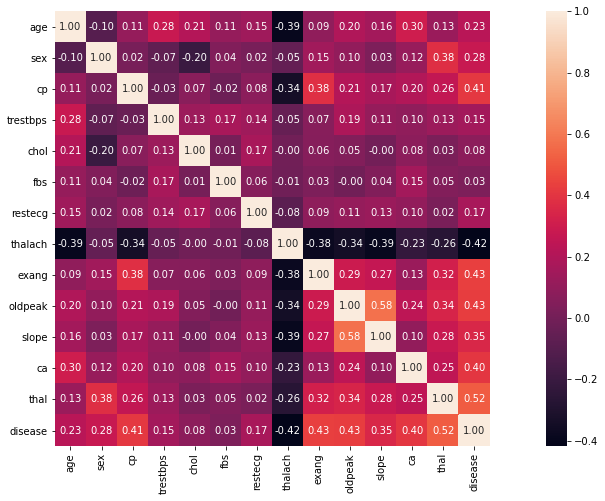

In [7]:
plt.figure(figsize=(20, 8))
sns.heatmap(hdisease.corr(), annot=True, square=True, fmt='0.2f')

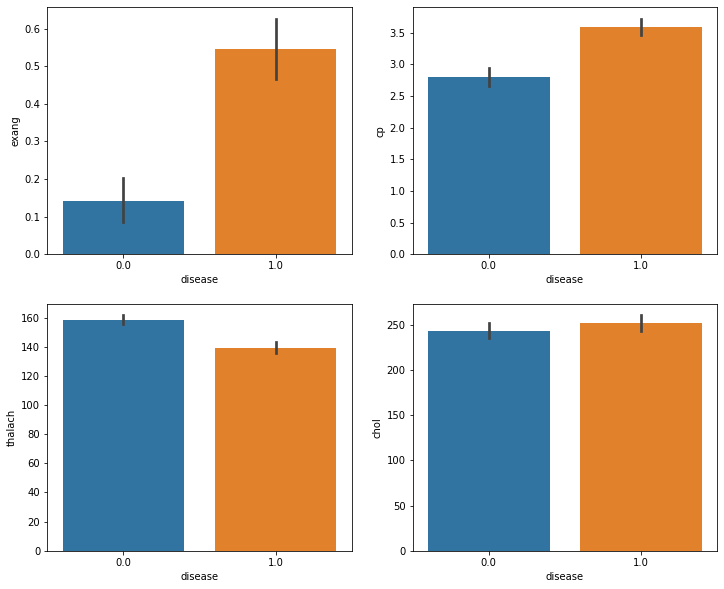

In [13]:
_, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.barplot(x='disease', y='exang', data=hdisease, ax=axes[0, 0])
sns.barplot(x='disease', y='cp', data=hdisease, ax=axes[0, 1])
sns.barplot(x='disease', y='thalach', data=hdisease, ax=axes[1, 0])
sns.barplot(x='disease', y='chol', data=hdisease, ax=axes[1, 1])

Most features are highly correlated to the disease column.
By interpreting the barplots of healthy and sick patients, it is likely that a patient with heart disease will have the following caracteristics:
- cp: more chest pain
- thalach: a lower maximum heart rate, surprisingly, high beats per minute is a signal of heart health
- exang: increase pain when exercising
- cholesterol levels are similar through sick and healthy patient: no direct link with heart disease

### Decision Trees
Decision trees are defined by recursively partitioning the input space into regions. Each region is partitioned into sub-regions up to a leaf node.
Space is sub-divided into non overlapping regions based on some criteria at each node. Once created, a tree can be navigated with a new sample of data following each branch according to the conditions. Each leaf node maps the input to a class or continuous value depending on the task. 
To understand how to grow a tree, we must introduce the gini index first.
Assuming that $D$ is the data in a leaf and $N$ the number of samples in $D$, we estimate the class-conditional probability as follow:
$$
    \hat{\pi}_c = \frac{1}{N} \sum_{i \in D}\mathbb{I}(y_i = c)
$$<br>
where $c$ are the classes of the target. The Gini index of a given leaf is:<br>
$$
    \large G_{l} = \sum_{c=1}^{C}\hat{\pi}_c(1 -\hat{\pi}_c) = 1 - \sum_{c=1}^{C}\hat{\pi}^2_c
$$

To have the Gini index of a split, we compute the Gini index on each of its leaves and multiply each of them by the proportion of samples in each leaves and sum both values:

$$
    \large G_{Node} = \sum_{i=1}^{K} \frac{k_{li}}{U}G_{li}
$$<br>
where $K$ is the number of leaves of the node, $k_{li}$ is the number of samples in the leaf $i^{th}$ leaf and $U$ is the number of sample to split.
            
In the case of categorical inputs, the most common approach is to consider the split condition as $x_{ij} = c_k$ or $x_{ij} \neq c_k$, for each possible class label $c_k$.
The rule to perform a split on a node is as follows:
- if the node is in the maximum depth of the tree, keep it as a leaf.
- for each attribute, we try all the possible thresholds and compute the Gini index of each split, the threshold across all attributes that minimize the Gini index is selected.
- a node is said pure if the split generates a empty leaf, if a node is pure, it is set as a leaf.
- if the node has a lowest score than the Gini index of the best split, we keep it as a leaf.

In [9]:
# Check which data are categorical or not
is_categorical = []
for col in hdisease.columns:
    # If less than 9 unique values, than the feature is categorical
    is_categorical.append(int(len(np.unique(hdisease[col])) < 9))
# Convert to Pytorch tensor
is_categorical = torch.tensor(is_categorical)[:-1]

In [10]:
# Convert data to numpy
data = hdisease.values
# Get unique values of the target
utarget = torch.from_numpy(np.unique(data[:, -1]))

### Convert data to Pytorch

In [11]:
X = torch.from_numpy(data[:, :-1])
y = torch.from_numpy(data[:, -1]).int()

### Node class

In [29]:
class Node():
    """Base class for a tree node
    
    We will use a single class to have the options to build a Decision Tree,
    a Random Forest and Adaboost.
    
    Attributes:
        X: A torch tensor for the data.
        y: A torch tensor for the labels.
        is_categorical_list: A list of boolean, 1 if the features is categorical,
            0 otherwise.
        max_depth: A positive integer for the depth of the tree.
        columns: A list of the name of each column.
        depth: A positive integer for the depth of the node.
        nb_features: A positive integer for selecting a number of random
            features for the split. Only used when training a Random Forest.
        weights: A torch tensor for computing the weighted gini index.
            Only used when training Adaboost.
        col_perm: A torch tensor of the permuted column. Only for Random Forests.
        X_full: A torch tensor that is keeping the whole data in case we shuffle
            the input for training a Random Forest.
        col_full: A list that keeps the whole feature names. Only for Random Forests.
        is_catfull: A list that keeps the whole is_categorical_list if training a
            Random Forest.
        size: A positive integer for the number of samples.
        nb_features: A positive integer for the number of features
        cutoff: A float for the splitting value of the node.
        col: A positive integer as an index for which column to apply the condition
            for the split.
        left: A Node class for the left child node.
        right: A Node class for the right child node.
        
    """
    def __init__(self, X, y, is_categorical, max_depth, columns, depth=0, nb_features=0, weights=None):
        """Init function of the class
            
        This function builds the whole tree, recursively creating each child node down
        to the leaves.
        
        Args:
            Described in the attribute section of the class
        """
        # If training random forest 
        if nb_features != 0:
            self.col_perm = torch.randperm(X.shape[1])[:nb_features]
            # We have to keep the permutated data as well as the full data
            # because we have to pass the full data to the child nodes
            self.X = X[:, self.col_perm]
            self.X_full = X
            self.columns = columns[self.col_perm]
            self.col_full = columns
            self.is_categorical_list = is_categorical[self.col_perm]
            self.is_catfull = is_categorical
        else:
            # Regular training of the decision tree
            self.X = X
            self.columns = columns
            self.is_categorical_list = is_categorical
        # Weights are used to compute a weighted gini index
        # Only when training AdaBoost
        self.weights = weights
        self.y = y
        self.size = float(X.shape[0])
        # Prediction if the node will turn into a leaf, or split value
        self.cutoff = None
        # Column to check for splitting the data 
        self.col = None
        # Child nodes
        self.left = None
        self.right = None
        # Whether or not the split value is categorical
        self.depth = depth
        self.nb_features = nb_features
        # If the node contains only one label, it is set as a leaf
        if self.is_pure() or depth == max_depth or self.X.shape[0] == 1:
            # Select the predominant categorical value and set it as the prediction
            self.make_leaf()
            return
            
        # Computing the gini index on the population before the split
        gini_n = self.gini(y, self.weights)
        params = self.find_best_split()
        
        gini_s = params[0]
        # If no improvement, make the node as a leaf
        if gini_s >= gini_n:
            self.make_leaf()
        else:
            self.make_split(params, max_depth)

    def gini(self, y, weights=None):
        """Computes the gini index
        
        Args:
            y: A torch tensor for the labels of the data.
            weights: If training a Random Forest, the weights associated
                with each sample.
        """
        if weights is None:
            # Regular gini index
            pi = y.bincount() / float(y.shape[0])
        else:
            # Weighted gini index
            pi = self.get_weighted_population(y, weights)
        return 1 - pi.pow(2).sum()
    
    # For weighted gini index:
    def get_weighted_population(self, y, weights):
        """Computes the weighted gini index
        
        Instead of counting the samples for each class
        we count the weights of each class and divide by the sum of the weights
        
        Args:
            y: A torch tensor for the labels of the data.
            weights: If training a Random Forest, the weights associated
        """
        pi = torch.zeros((2,), dtype=torch.float32)
        idx_0 = torch.where(y == 0)[0]
        idx_1 = torch.where(y == 1)[0]
        pi[0] = weights[idx_0].sum()
        pi[1] = weights[idx_1].sum()
        return pi / weights.sum()
        
    def clean_attributes(self):
        """Cleans variables that are not usefull to predict"""
        del(self.X)
        del(self.y)
        del(self.weights)
        del(self.size)
        if self.nb_features != 0:
            del(self.X_full)
            del(self.col_full)
            del(self.is_catfull)
            del(self.colperm)
        del(self.nb_features)
    
    def is_pure(self):
        """Checks if the node is pure
        
        The node is pure if there is only one label in the population
        """
        return len(self.y.unique()) == 1
    
    def get_label(self):
        """Returns the most present label as a prediction if the node turns to a leaf"""
        if self.weights is None:
            return self.y.bincount().argmax().item()
        else:
            return self.get_weighted_population(self.y, self.weights).argmax().item()
    
    def make_leaf(self):
        """Makes the node a leaf"""
        self.cutoff = self.get_label()
        self.clean_attributes()
    
    def make_split(self, params, max_depth):
        """Performs the split
        
        Args:
            params: See find_best_split function
            max_depht: A positive integer for the maximum of the tree.
        """
        self.col = params[1]
        self.cutoff = params[2]
        # Save the categorical boolean of the selected column for the predict method
        self.var_categorical = self.is_categorical_list[self.col].item()
        # Recursively split by creating two instances of the Node class using the two groups
        if self.nb_features != 0:
            cols = self.col_full
            categorical_list = self.is_catfull
        else:
            cols = self.columns
            categorical_list = self.is_categorical_list
        # Creating child nodes based on the best params
        # If training Random Forest, we pass nb_features
        # If training AdaBoost, we pass the weights
        self.left = Node(X=params[3][0],
                         y=params[3][1],
                         is_categorical=categorical_list,
                         max_depth=max_depth,
                         columns=cols,
                         depth=self.depth + 1,
                         nb_features=self.nb_features,
                         weights=params[5])
        self.right = Node(X=params[4][0],
                          y=params[4][1],
                          is_categorical=categorical_list,
                          max_depth=max_depth,
                          columns=cols,
                          depth=self.depth + 1,
                          nb_features=self.nb_features,
                          weights=params[6])
        self.clean_attributes()
   
    def gini_split(self, idx_g_1, idx_g_2, cutoff, feature_idx, best_params):
        """Computes the gini index of the future split
        
        Args:
            idx_g_1: A torch tensor for the indices of the first group.
            idx_g_2: A torch tensor for the indices of the second group.
            cutoff: A float for the split value.
            feature_idx: A positive integer for the index of the feature to test.
            best_params: See function find_best_split
        """
        g_1 = self.y[idx_g_1].squeeze(1)
        g_2 = self.y[idx_g_2].squeeze(1)
        if self.weights is  None:
            #Gini index
            gini_g1 = (float(g_1.shape[0]) / self.size) * self.gini(g_1)
            gini_g2 = (float(g_2.shape[0]) / self.size) * self.gini(g_2)
        else:
            # Weighted gini index
            g_1_w = self.weights[idx_g_1]
            g_2_w = self.weights[idx_g_2]
            w_sum = self.weights.sum()
            gini_g1 = (g_1_w.sum() / w_sum) * self.gini(g_1, g_1_w)
            gini_g2 = (g_2_w.sum() / w_sum) * self.gini(g_2, g_2_w) 
            
        gini_split = (gini_g1 + gini_g2)
        if gini_split < best_params[0]:
            best_params[0] = gini_split.item()
            best_params[1] = feature_idx
            best_params[2] = cutoff.item()
            # If training a base learner of a random forest
            # pass the full data to child nodes
            if self.nb_features != 0:
                best_params[3] = [self.X_full[idx_g_1].squeeze(1), g_1]
                best_params[4] = [self.X_full[idx_g_2].squeeze(1), g_2]
            else:
                best_params[3] = [self.X[idx_g_1].squeeze(1), g_1]
                best_params[4] = [self.X[idx_g_2].squeeze(1), g_2]
            if self.weights is not None:
                # Gather weights of each groups to pass them to the child nodes
                # for their own weighted gini index
                best_params[5] = g_1_w
                best_params[6] = g_2_w
        return best_params
    
    def find_best_split(self):
        """Finds the best split
        
            Creates a parameter list to store the parameters of the best split
            It contains:
            0: best gini index
            1: column index of the best split
            2: value of the best split
            3: left group [X, y], less than equal to #3 or belongs to the class #3 if categorical
            4: right group [X, y], greater than #3 or does not belong to the class #3
            5 : weights of the first group
            6 : weights of the second group
        """
        best_params = [2, -1, -1, None, None, None, None]
        for i in range(self.X.shape[1]):
            vals = self.X[:, i]
            if self.is_categorical_list[i]:
                for cutoff in vals.unique():
                    idx_uv = (vals == cutoff).nonzero()
                    idx_uv_not = (vals != cutoff).nonzero()
                    best_params = self.gini_split(idx_uv, idx_uv_not, cutoff, i, best_params)
            else:
                for cutoff in vals.unique():
                    idx_leq = (vals <= cutoff).nonzero()
                    idx_ge = (vals > cutoff).nonzero()
                    best_params = self.gini_split(idx_leq, idx_ge, cutoff, i, best_params)
        return best_params
    
    def get_dict(self):
        """Returns a dictionary containing nodes and their information"""
        node_dict = {}
        if self.left is None and self.right is None:
            node_dict['pred'] = self.cutoff
        else:
            node_dict['cutoff'] = self.cutoff
            node_dict['feature'] = self.columns[self.col]
            node_dict['categorical'] = self.var_categorical
            node_dict['left'] = self.left.get_dict()
            node_dict['right'] = self.right.get_dict()
        return node_dict
   
    def predict(self, sample):
        """Takes a single input and predicts its class
        
            Follows the tree based on the conditions
        """
        if self.nb_features != 0:
            sample_in = sample[self.col_perm]
        else:
            sample_in = sample
        if self.left is None and self.right is None:
            return self.cutoff
        if self.var_categorical:
            if sample_in[self.col] == self.cutoff:
                return self.left.predict(sample)
            else:
                return self.right.predict(sample)
        else:
            if sample_in[self.col] <= self.cutoff:
                return self.left.predict(sample)
            else:
                return self.right.predict(sample)

### Decision Tree Class

In [14]:
# Class that implements the sklearn methods
# Just a wrapper for our node class
class DecisionTreeClassifier(BaseEstimator):
    """Class for the Decision Tree Classifier
    
    Class that implements the sklearn methods
    Just a wrapper for our node class
    
    Attributes:
        max_depth: A positive integer for the maximum depth of the tree.
        columns: A list of the name of each column.
        nb_features: A positive integer for the number of features
        is_categorical: A list of boolean, 1 if the features is categorical,
    """
    def __init__(self, max_depth, is_categorical, columns, nb_features=0):
        """Inits the Decision Tree class
        
        Args:
            See attributes section.
        """
        if nb_features < 0:
            raise ValueError('negative integer passed to nb_features.')
        self.max_depth = max_depth
        # Wether or not each column is a categorical value
        self.is_categorical = is_categorical
        self.columns = columns
        self.root = None
        # Number of random features to select
        # Only used when building a random forest base learner
        # If 0 then train a decision tree using all the features availables
        self.nb_features = nb_features
    
    def fit(self, X, y, **kwargs):
        """Trains the model
        
        Needs to get the 'sample_weight' key in kwargs.
        Mandatory for using sklearn cross validation.
        
        Args:
            X: A torch tensor for the data.
            y: A torch tensor for the labels.
        """
        if self.nb_features > X.shape[1]:
            raise ValueError('parameter np_features should be less than equal to the number of features')
        if 'sample_weight' in kwargs.keys():
            weights = kwargs['sample_weight']
        else:
            weights = None
        self.root = Node(X, y, self.is_categorical, self.max_depth, self.columns, 0, self.nb_features, weights)
        
    def predict(self, X):
        """Predicts the labels of a batch of input samples"""
        if len(X.shape) == 0:
            return 'error: can not predict on empty input.'
        if len(X.shape) == 1:
            return self.root.predict(X)
        
        pred = torch.zeros((X.shape[0],), dtype=torch.int32)
        if self.root == None:
            return 'error: use the fit method before using predict.'
        for i in range(X.shape[0]):
            sample = X[i, :]
            pred[i] = self.root.predict(sample)
        return pred
    
    def __str__(self):
        """Method for printing the tree"""
        if self.root == None:
            return 'error: use the fit method to print the result of the training.'
        tree_dict = self.root.get_dict()
        pprint(tree_dict)
        return ''

In [62]:
dt = DecisionTreeClassifier(max_depth=3,
                            is_categorical=is_categorical,
                            columns=hdisease.columns,
                            nb_features=13)
dt.fit(X, y)
print(dt)

{'categorical': 1,
 'cutoff': 3.0,
 'feature': 'thal',
 'left': {'categorical': 1,
          'cutoff': 0.0,
          'feature': 'ca',
          'left': {'categorical': 0,
                   'cutoff': 156.0,
                   'feature': 'trestbps',
                   'left': {'pred': 0},
                   'right': {'pred': 1}},
          'right': {'categorical': 1,
                    'cutoff': 4.0,
                    'feature': 'cp',
                    'left': {'pred': 1},
                    'right': {'pred': 0}}},
 'right': {'categorical': 1,
           'cutoff': 4.0,
           'feature': 'cp',
           'left': {'categorical': 0,
                    'cutoff': 0.5,
                    'feature': 'oldpeak',
                    'left': {'pred': 1},
                    'right': {'pred': 1}},
           'right': {'categorical': 1,
                     'cutoff': 0.0,
                     'feature': 'ca',
                     'left': {'pred': 0},
                     'right': {'pred

We just fit the whole data to the model to visualize the structure of the tree.<br>
In the next section, we will validate the performance of the model using cross validation and have an interpretation of the tree structure.

### Cross Validation

In [63]:
dt = DecisionTreeClassifier(max_depth=3,
                            is_categorical=is_categorical,
                            columns=hdisease.columns,
                            nb_features=13)
# Using 5 K-folds
test_acc = cross_val_score(dt, X, y, scoring='accuracy', cv=5).mean()
print('Accuracy on the test set:', test_acc)

Accuracy on the test set: 0.8110382513661202


Using cross validation and accuracy as our metric, the model performed well for such a simple classifier.
Indeed, 81% accuracy on a 5 k-fold cross validation is acceptable given the complexity of predicting heart disease.
Looking at the tree structure, the first split is done on the 'thal' feature which has the highest correlation with the target.
The most discriminative features are then 'ca', 'cp' and 'oldpeak' and they all have more than 40% correlation with the target.
The model uses lower correlated variable such as 'chol' and 'testbps' inside the deeper nodes.

The 'thal' feature contributes the most in the decision. It refers to the Thalium stress test result, consisting in injecting radioactive element into the bloodstream of the patient. The 'thal' categorical values refers to the quality of blood circulation. It makes sense that a patient with poor blood circulation is very likely to have a heart disease.

The performance using a decision tree is acceptable, but let's try to do better using a Random Forest.

### Random Forest
Random forest is a technique known as bootstrap aggregating (bagging) which consists in taking multiple different models and compute the ensemble prediction:

$$
    f(\boldsymbol{x}) = \sum_{i = 0}^{M}f_m(\boldsymbol{x})
$$

where $f_m$ is the $m^{th}$ model.<br>
The random forest technique is an ensemble model using decision trees as base learners. This ensemble model tries to decorrelate the base
learners by learning trees on a randomly chosen subset of features, as well as a randomly chosen subset of samples.

In other words, to train a random forest, we create $m$ subsets of the training set where we can select multiple times the same samples. These subsets are known as boostrapped datasets. Finally, each base learner is trained in the same fashion as a decision tree except that at each node, when we perform the split, we randomly choose a fixed number of features from the data.

In [33]:
class RandomForestClassifier(BaseEstimator):
    """Class for the Random Forest model
    
    Implements the BaseEstimator sklearn class to use cross validation.
    
    Attributes:
        max_depth: A positive integer for the maximum depth of the tree.
        columns: A list of the name of each column.
        nb_features: A positive integer for the number of features
        is_categorical: A list of boolean, 1 if the features is categorical,
        n_estimators: A positive integer for the number of estimators in the ensemble.
        trees: A list of DecisionTreeClassifiers class of the ensemble.
    """
    def __init__(self, max_depth, is_categorical, columns, nb_features, n_estimators):
        """Inits the Random Forest class
        
        Args:
            See attribute section.
        """
        self.max_depth = max_depth
        self.is_categorical = is_categorical
        self.columns = columns
        self.nb_features = nb_features
        # Number of trees in the ensemble model
        self.n_estimators = n_estimators
        self.trees = []
        
    def fit(self, X, y, **kwargs):
        """Trains the random forest"""
        if self.nb_features > X.shape[1]:
            raise ValueError('parameter np_features should be less than equal to the number of features') 
        for i in range(self.n_estimators):
            # Create boostrapped subset
            X_bstrp, y_bstrp = self.get_boostrap_data(X, y)
            dt = DecisionTreeClassifier(self.max_depth, self.is_categorical, self.columns, self.nb_features)
            # Train on the boostrapped subst
            dt.fit(X_bstrp, y_bstrp)
            self.trees.append(dt)
        
    def get_boostrap_data(self, X, y):
        """Returns the data and labels randomly shuffled"""
        idx = torch.randint(0, X.shape[0] - 1, size=(X.shape[0],))
        return X[idx, :], y[idx]
   
    def predict_sample(self, X):
        """Predicts on one sample"""
        preds = np.array([0, 0])
        # Predict with each base learner and return the most voted class
        for tree in self.trees:
            preds[tree.predict(X)] += 1
        return preds.argmax() 

    def predict(self, X):
        """Predicts on a batch of samples"""
        if len(X.shape) == 0:
            return 'error: can not predict on empty input.'
        if len(X.shape) == 1:
            return self.predict_sample(X)
        
        pred = torch.zeros((X.shape[0],), dtype=torch.int32)
        if len(self.trees) == 0:
            return 'error: use the fit method before using predict.'
        for i in range(X.shape[0]):
            sample = X[i, :]
            pred[i] = self.predict_sample(sample)
        return pred

In [60]:
max_depth_params = [3, 4]
nb_features_params = [i for i in range(2, 10)]
for _ in range(20):
    max_depth = np.random.choice(max_depth_params)
    nb_features = np.random.choice(nb_features_params) 
    rf = RandomForestClassifier(max_depth=max_depth,
                                is_categorical=is_categorical,
                                columns=hdisease.columns,
                                nb_features=nb_features,
                                n_estimators=100)
    # Using 5 K-folds
    test_acc = cross_val_score(rf, X, y, scoring='accuracy', cv=5).mean()
    print('Test accuracy:\t' + str(test_acc) + ', nb features:\t' + str(nb_features) + ', max depth:\t', str(max_depth))

Test accuracy:	0.8342622950819673, nb features:	7, max depth:	 3
Test accuracy:	0.8243169398907104, nb features:	6, max depth:	 4
Test accuracy:	0.8242076502732241, nb features:	6, max depth:	 3
Test accuracy:	0.8243715846994537, nb features:	8, max depth:	 3
Test accuracy:	0.8408743169398907, nb features:	6, max depth:	 3
Test accuracy:	0.8275956284153005, nb features:	8, max depth:	 3
Test accuracy:	0.834153005464481, nb features:	8, max depth:	 3
Test accuracy:	0.8243169398907104, nb features:	4, max depth:	 3
Test accuracy:	0.830928961748634, nb features:	6, max depth:	 3
Test accuracy:	0.8342076502732242, nb features:	2, max depth:	 3
Test accuracy:	0.8340983606557376, nb features:	7, max depth:	 4
Test accuracy:	0.8175409836065575, nb features:	8, max depth:	 4
Test accuracy:	0.8375956284153006, nb features:	4, max depth:	 3
Test accuracy:	0.8341530054644808, nb features:	9, max depth:	 3
Test accuracy:	0.8308743169398907, nb features:	5, max depth:	 3
Test accuracy:	0.8275956284

After a quick parameter search, the best model achieves 84.4% accuracy. A great improvement of 3% comparing to a single decision tree.<br>
To go further we will try a technique known as boosting.

### Boosting
Boosting is an algorithm using multiple weak learners. A weak learner is defined to be slightly better than random guessing. The most common weak learner is known as a  stamp. A stamp is an univariate tree with only one split. The purpose of boosting is to sequentially apply the weak classification algorithm to repeatedly modified versions of the data.

The predictions from the weak learners are combined through a weighted majority vote:

$$
   \large f(\boldsymbol{x}) = \text{sign}\left(\sum_{m=1}^{M}\alpha_m f_m(\boldsymbol{x})\right)
$$

where $f(\boldsymbol{x})$ is the prediction of the final model, $f_m(\boldsymbol{x})$ is the prediction of the weak learner $m$ and $\{\alpha_1, \dots, \alpha_M\}$ are the weights computed by the boosting algorithm. Their effect is to give higher influence to the more accurate 
learners. This formula represent the prediction in case of a binary classification $\{-1, 1\}$
            
The data modification consists of applying weights $\{\boldsymbol{w_1}, \dots, \boldsymbol{w_N}\}$ to each training samples. Initially the weights are set to $\frac{1}{N}$ where $N$ is the number of samples. At iteration $k$, we perform a data transformation using the weights on each training samples. We fit the data into the model and the samples that were misclassified by the learner $f_{k-1}$ have their weights increased while the samples that were well classified by $f_{k-1}$ have their weights decreased. The importance of the harder samples sequentially increase and the learners are forced to concentrate on the observation that are missed on the previous iterations.

AdaBoost, short for Adaptative Boosting, is the first boosting technique that got popular for being able to adapt to the weak learners.
In this algorithm, after fitting the weak learner $m$, we compute the weighted error:

$$
    \large \text{err}_m = \frac{1}{N}\sum_{i=1}^{N}w_i I\left(y_i \neq f_m(\boldsymbol{x_i})\right)
$$

Then we set the weights of the model in the final prediction based on its performance:

$$
    \large \alpha_m = \log\left(\frac{1 - \text{err}_m}{\text{err}_m}\right)
$$

Finally, we update the weights of each samples as follow:

$$
    \large
    \begin{align}
    w_i = w_i * \exp(\alpha_m I\left(y_i \neq f_m(\boldsymbol{x}_i)\right)\\
    w_i = w_i * \exp(-\alpha_m I\left(y_i = f_m(\boldsymbol{x}_i)\right)
    \end{align}
$$

The importance of the weak learner's weight is proportional to its performance during training.<br>
In fact, if $err_m$ is low then $\alpha_m$ is high and the values of the sample weights $w_1, \dots, w_N$ get modified by a higher margin.<br>
The misclassified samples are scaled up and the well classified samples are scaled down so that the learner will focus on the weakness of the previous one.<br>

Inside the stamps, the splits are selected according to the weighted gini split:

$$
    \large
    \begin{align}
    \hat{\pi}_c = \frac{1}{\sum_{i=1}^{N}w_i} \sum_{i \in D}w_i\mathbb{I}(y_i = c)\\
    \text{G} = 1 - \sum_{c=1}^{C}\hat{\pi}^2_c
    \end{align}
$$

Here the samples with high weights contribute more to the gini index than the lower ones.<br>

In [64]:
class AdaBoostClassifier(BaseEstimator):
    """Class of the Adaboost model
    
    Attributes:
        columns: A list of the name of each column.
        is_categorical: A list of boolean, 1 if the features is categorical,
        n_estimators: A positive integer for the number of estimators in the ensemble.
        learners: A list of DecisionTreeClassifiers for the stamps of the ensemble. 
        alphas: A torch tensor for the weights defining the importance of each learner
            in the final prediction.
    """
    def __init__(self, n_estimators=50, is_categorical=None, columns=None):
        self.n_estimators = n_estimators
        self.learners = []
        self.alphas = None
    
    def compute_weighted_err(self, y_true, y_pred, weights):
        """Computes a weighted error based on the weight associated with the samples"""
        idx_neq = torch.where(y_true != y_pred)[0]
        return weights[idx_neq].sum() / weights.sum()
    
    def set_alpha(self, err):
        """Updates the new weights of the models"""
        return torch.log((1 - err) / (err + 1e-10)) / 2
    
    def update_weights(self, weights, y_true, y_pred, alpha):
        """Updates the weights of the samples
        
        Args:
            weights: A torch tensor for the weights of each samples.
            y_true: A torch tensor for the labels of the data.
            y_pred: A torch tensor for the predictions of the model.
            alpha: A float for the weight of a learner.
        """
        if len(y_true.shape) == 1:
            y_true = y_true.unsqueeze(1)
        if len(weights.shape) == 1:
            weights = weights.unsqueeze(1)
        weights *= torch.exp(alpha * (y_pred != y_true).int())
        weights *= torch.exp(-alpha * (y_pred == y_true).int())
        weights /= weights.sum()
        return weights
    
    def fit(self, X, y, **kwargs):
        """Trains the model
        
        Args:
            X: A torch tensor for the data.
            y: A torch tensor for the labels.
        """
        if len(y.shape) == 1:
            y = y.unsqueeze(1)
        
        size = X.shape[0]
        # Initialize weights to 1/size
        weights = torch.empty((size,)).fill_(1 / size)
        alphas = torch.zeros((self.n_estimators, 1))
        
        for i in range(self.n_estimators):
            if len(weights.shape) > 1:
                weights = weights.squeeze(1) 
                
            # Each learner is a stamp:
            # it has only one split and is using only one feature
            dtc = DecisionTreeClassifier(max_depth=1, is_categorical=is_categorical, columns=columns, nb_features=0)
            dtc.fit(X, y, sample_weight=weights)
            pred = dtc.predict(X).unsqueeze(1)
            self.learners.append(dtc)
            
            # Compute weighted error
            err = self.compute_weighted_err(y, pred, weights)
            # Set weight of the learner
            new_alpha = self.set_alpha(err)
            alphas[i] = new_alpha
            # Update weights
            weights = self.update_weights(weights, y, pred, new_alpha)
        self.alphas = alphas
    
    def predict(self, X):
        """Predicts the labels of a batch of data"""
        size = X.shape[0]
        preds = torch.zeros((size, 1), dtype=torch.float32)
        for i in range(self.n_estimators):
            pred = self.learners[i].predict(X).unsqueeze(1)
            # Change zeros to -ones to apply to sign formula discussed above
            pred[pred == 0] = -1
            preds += self.alphas[i] * pred
        preds = torch.sign(preds)
        preds[preds == -1] = 0
        return preds

In [59]:
for i in range(10, 150, 10):
    adaboost = AdaBoostClassifier(n_estimators=i, is_categorical=is_categorical, columns=hdisease.columns)
    fit_params = {
        'n_estimators' : i,
        'is_categorical' : is_categorical,
        'columns' : hdisease.columns
    }
    test_acc = cross_val_score(adaboost, X, y, scoring='accuracy', cv=5).mean()
    print('Test accuracry: ' + str(test_acc) + ', n_estimators: ' + str(i))

Test accuracry: 0.8374316939890709, n_estimators: 10
Test accuracry: 0.8340437158469944, n_estimators: 20
Test accuracry: 0.837377049180328, n_estimators: 30
Test accuracry: 0.8274863387978142, n_estimators: 40
Test accuracry: 0.8440437158469946, n_estimators: 50
Test accuracry: 0.827431693989071, n_estimators: 60
Test accuracry: 0.8341530054644808, n_estimators: 70
Test accuracry: 0.8275409836065574, n_estimators: 80
Test accuracry: 0.8308743169398907, n_estimators: 90
Test accuracry: 0.8308196721311475, n_estimators: 100
Test accuracry: 0.8274863387978142, n_estimators: 110
Test accuracry: 0.8175956284153004, n_estimators: 120
Test accuracry: 0.8142622950819671, n_estimators: 130
Test accuracry: 0.8274863387978142, n_estimators: 140


AdaBoost achieved 84.4% accuracy on this data, the exact same performance as the random forest.

### Conclusion
Decision Trees are very prized by the machine learning community for their interpretability and their handy automatic feature selection.
Unfortunately, the decision trees tend to overfit. It is mandatory to limit the max depth parameter to avoid this behavior. Using the ensemble technique is a great way to deal with the tendency of the decision trees to overfit. However, as the model is getting more complex due to aggregation of multiple learners, it is more challenging to interpret a Random Forest or an AdaBoost model.